In [3]:
%matplotlib inline
import numpy as np
import math
from scipy.signal import freqz
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [4]:
ctrl = [
    {"type": "highpass", "f": 60},
    {"type": "band", "f": 250, "gain": 6, "q": 2},
    {"type": "band", "f": 250, "gain": -6, "q": 2},
    {"type": "notch", "f": 125},
    {"type": "band", "f": 2000, "gain": 6, "q": 4},
    {"type": "lowpass", "f": 8000},
]

(10, 24000)

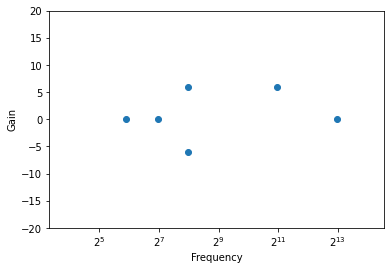

In [5]:
x = []
y = []
s = []

for fltr in ctrl:
    x.append(fltr["f"])
    if "gain" in fltr:
        y.append(fltr["gain"])
    else:
        y.append(0)
    s.append(1)


plt.scatter(x, y)
plt.xlabel("Frequency")
plt.ylabel("Gain")
plt.ylim([-20, 20])
plt.xscale("log", base=2)
plt.xlim([10, 24000])


In [15]:
class BiQuad:
    def __init__(self):
        self.b0 = 1
        self.b1 = 1
        self.b2 = 1
        self.a0 = 1
        self.a1 = 1
        self.a2 = 1
        
    def normalize(self):
        self.b0 /= self.a0
        self.b1 /= self.a0
        self.b2 /= self.a0
        self.a1 /= self.a0
        self.a2 /= self.a0
        self.a0 = 1.0
        
    def get_coeff(self):
        return ([self.b0, self.b1, self.b2], [self.a0, self.a1, self.a2])
    
    def calculate(self, f):
        phi = (math.sin(math.pi * f * 2/(2*48000)))**2
        r =((self.b0+self.b1+self.b2)**2 - \
        4*(self.b0*self.b1 + 4*self.b0*self.b2 + \
        self.b1*self.b2)*phi + 16*self.b0*self.b2*phi*phi) / \
        ((1+self.a1+self.a2)**2 - 4*(self.a1 + 4*self.a2 + \
        self.a1*self.a2)*phi + 16*self.a2*phi*phi)
        if(r < 0):
          r = 0
        r = r**(.5)
        try:
            return 20 * math.log10(r)
        except:
            return -200

class HighPass(BiQuad):
    def __init__(self, frequency):
        w0 = (2 * math.pi * frequency) / 48000
        s0 = math.sin(w0)
        c0 = math.cos(w0)
        q = 0.7071
        alpha = s0 / (2 * q)
        self.b0 = (1 + c0) / 2
        self.b1 = -(1 + c0)
        self.b2 = (1 + c0) / 2
        self.a0 = 1 + alpha
        self.a1 = -2 * c0
        self.a2 = 1 - alpha
        
class LowPass(BiQuad):
    def __init__(self, frequency):
        w0 = (2 * math.pi * frequency) / 48000
        s0 = math.sin(w0)
        c0 = math.cos(w0)
        q = 0.7071
        alpha = s0 / (2 * q)
        self.b0 = (1 - c0) / 2
        self.b1 = 1 + c0
        self.b2 = (1 - c0) / 2
        self.a0 = 1 + alpha
        self.a1 = -2 * c0
        self.a2 = 1 - alpha
        
class Peaking(BiQuad):
    def __init__(self, frequency, gain, q):
        A = math.pow(10, gain / 40)
        w0 = (2 * math.pi * frequency) / 48000
        if q == 0:
            q = 1
        alpha = math.sin(w0) / (2 * q)
        self.b0 = 1 + alpha * A
        self.b1 = -2 * math.cos(w0)
        self.b2 = 1 - alpha * A
        self.a0 = 1 + alpha / A
        self.a1 = -2 * math.cos(w0)
        self.a2 = 1 - alpha / A
        
class Notch(BiQuad):
    def __init__(self, frequency, q):
        w0 = (2 * math.pi * frequency) / 48000
        if q == 0:
            q = 1
        alpha = math.sin(w0) / (2 * q)
        self.b0 = 1
        self.b1 = -2 * math.cos(w0)
        self.b2 = 1
        self.a0 = 1 + alpha
        self.a1 = -2 * math.cos(w0)
        self.a2 = 1 - alpha

class HighShelf(BiQuad):
    def __init__(self, frequency, gain):
        A = math.pow(10, gain / 40)
        w0 = (2 * math.pi * frequency) / 48000
        s0 = math.sin(w0)
        c0 = math.cos(w0)
        beta = math.sqrt(A + A)
        self.b0 = A * ((A + 1) + (A - 1) * c0 + beta * s0)
        self.b1 = -2 * A * ((A - 1) + (A + 1) * c0)
        self.b2 = A * ((A + 1) + (A - 1) * c0 - beta * s0)
        self.a0 = (A + 1) - (A - 1) * c0 + beta * s0
        self.a1 = 2 * ((A - 1) - (A + 1) * c0)
        self.a2 = (A + 1) - (A - 1) * c0 - beta * s0

class LowShelf(BiQuad):
    def __init__(self, frequency, gain):
        A = math.pow(10, gain / 40)
        w0 = (2 * math.pi * frequency) / 48000
        s0 = math.sin(w0)
        c0 = math.cos(w0)
        beta = math.sqrt(A + A)
        self.b0 = A * ((A + 1) - (A - 1) * c0 + beta * s0)
        self.b1 = 2 * A * ((A - 1) - (A + 1) * c0)
        self.b2 = A * ((A + 1) - (A - 1) * c0 - beta * s0)
        self.a0 = (A + 1) + (A - 1) * c0 + beta * s0
        self.a1 = -2 * ((A - 1) + (A + 1) * c0)
        self.a2 = (A + 1) + (A - 1) * c0 - beta * s0


In [16]:
# 60Hz High pass filter
testfilter1 = HighPass(1400)
b1, a1 = testfilter1.get_coeff()
testfilter1.normalize()

# 2Khz band, gain=10dB, Q=4
testfilter2 = Peaking(2000, 6, 4)
b2, a2 = testfilter2.get_coeff()
testfilter2.get_coeff()
testfilter1.get_coeff()

testfilter3 = Notch(1100,7)
testfilter3.normalize()

testfilter4 = Notch(1000,7)
testfilter4.normalize()

testfilter5 = LowPass(4000)
testfilter5.normalize()

testfilter6 = LowShelf(4000, 6)
testfilter6.normalize()
testfilter6.get_coeff()

([1.1329663507257324, -1.3121235210942044, 0.4753337834674982],
 [1.0, -1.3859918589516194, 0.5344317963358153])

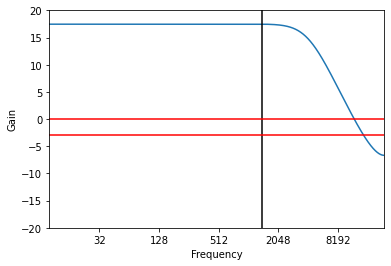

In [17]:
response = []
steps = []
for f in range(0,24000,10):
    steps.append(f)
    response.append(testfilter5.calculate(f))
plt.plot(steps, response)
plt.xlabel("Frequency")
plt.ylabel("Gain")
plt.xscale("log", base=2)
plt.xlim([10, 24000])
plt.ylim([-20, 20])
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())

plt.axvline(1400, color="k")
plt.axhline(0,color="r")
plt.axhline(-3,color="r")

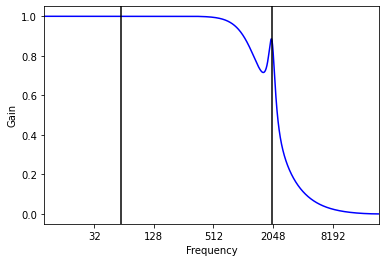

In [9]:
w1, h1 = freqz(b1, a1, fs=48000, worN=20480)
w2, h2 = freqz(b2, a2, fs=48000, worN=20480)
plt.plot(w1, np.abs(h1)*np.abs(h2), 'b')
plt.xlabel("Frequency")
plt.ylabel("Gain")
plt.xscale("log", base=2)
plt.xlim([10, 24000])
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())

plt.axvline(60, color="k")
plt.axvline(2000, color="k")